# This is the first version of building a Bayesian Network for risk management

In [3]:
#----------------------------------
# Try to build the BNs
#----------------------------------
import numpy as np
import pandas as pd


from pgmpy.base import DAG
from pgmpy.models import FunctionalBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.hybrid import FunctionalCPD
import pyro.distributions as dist

from pgmpy.models import BayesianNetwork
from pgmpy.sampling import GibbsSampling, BayesianModelSampling
from pgmpy.inference import VariableElimination


import matplotlib.pyplot as plt
from IPython.display import Image


## The BN with my thoughts

In [4]:
BN_risk = DAG()
BN_risk.add_nodes_from(nodes=['Building type', 'The type of roof', 'Height', 'Geometry data', 'The number of storey'])
BN_risk.add_edges_from(ebunch=[('Building type', 'Activation risk'),
                               ('Activation risk', 'The probability of fire occurance'),
                               ('The probability of fire occurance', 'The number of deaths')])
BN_risk.add_edges_from(ebunch=[('Geometry data', 'Area'),
                               ('Area', 'Volume'),
                               ('Height', 'Volume'),
                               ('The type of roof', 'Volume'),
                               ('Volume', 'The probability of fire occurance')])
BN_risk.add_edges_from(ebunch=[('Volume', 'The number of people'),
                               ('Height', 'The number of people'),
                               ('The number of storey', 'The number of people'),
                               ('Building type', 'The number of people'),
                               ('The number of people', 'The number of deaths')])
BN_risk.add_edges_from(ebunch=[('The probability of death', 'The number of deaths')])



/Users/chupei/Desktop/Test/.venv/lib/python3.13/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: using box for unknown shape rhomboid

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


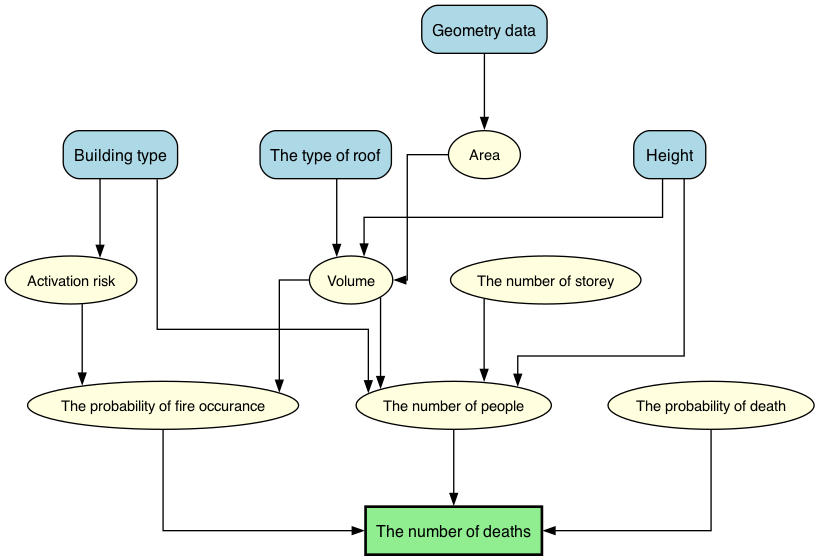

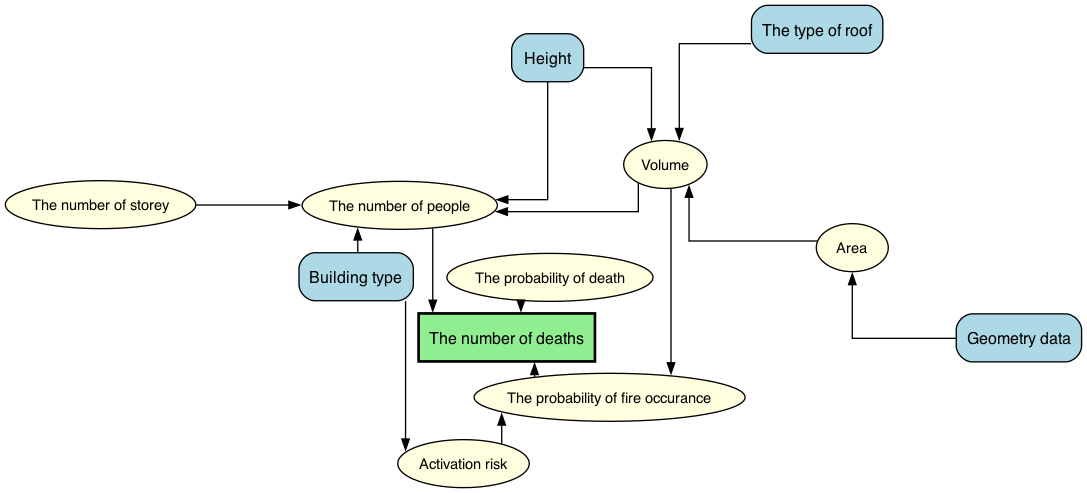

/Users/chupei/Desktop/Test/.venv/lib/python3.13/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: using box for unknown shape rhomboid

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


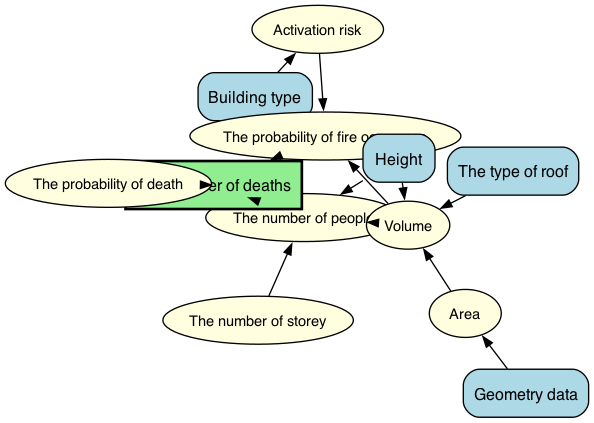

In [ ]:
try:
    # Create visualization with custom attributes
    viz = BN_risk.to_graphviz()
    
    # Define input and output nodes
    input_nodes = ['Building type', 'The type of roof', 'Height', 'Geometry data', 'The number of storeys']
                   
    output_nodes = ['The number of deaths']


    # Customize overall graph appearance
    viz.graph_attr.update({
        'rankdir': 'TB',        # top to bottom layout
        'splines': 'ortho',
        'nodesep': '0.6',
        'ranksep': '0.8'
    })

    # Default node attributes
    viz.node_attr.update({
        'shape': 'ellipse',     # default for causal nodes
        'style': 'filled',
        'fillcolor': 'lightyellow',
        'fontname': 'Helvetica',
        'fontsize': '11'
    })

    # Customize specific node types
    for node in BN_risk.nodes():
        if node in output_nodes:
            viz.get_node(node).attr.update({
                'shape': 'rhomboid',
                'fillcolor': 'lightgreen',
                'style': 'filled,bold',
                'fontsize': '12'
            })
        elif node in input_nodes:
            viz.get_node(node).attr.update({
                'shape': 'rectangle',
                'fillcolor': 'lightblue',
                'style': 'filled,rounded',
                'fontsize': '12'
            })
        else:
            # Causal (intermediate) nodes
            viz.get_node(node).attr.update({
                'shape': 'ellipse',
                'fillcolor': 'lightyellow',
                'style': 'filled',
                'fontsize': '11'
            })

    # Customize edges
    viz.edge_attr.update({
        'arrowsize': '0.8',
        'penwidth': '1.0'
    })

    
    
    
    
    # Generate layouts
    layouts = ['dot', 'fdp', 'sfdp', 'twopi', 'circo', 'neato']
    for layout in layouts:
        viz.draw(f'../Output/Model_images/model_{layout}.png', prog=layout)
        display(Image(f'../Output/Model_images/model_{layout}.png'))
        
except ImportError:
    print("Please install required packages:")
    print("brew install graphviz")
    print("pip install pygraphviz")

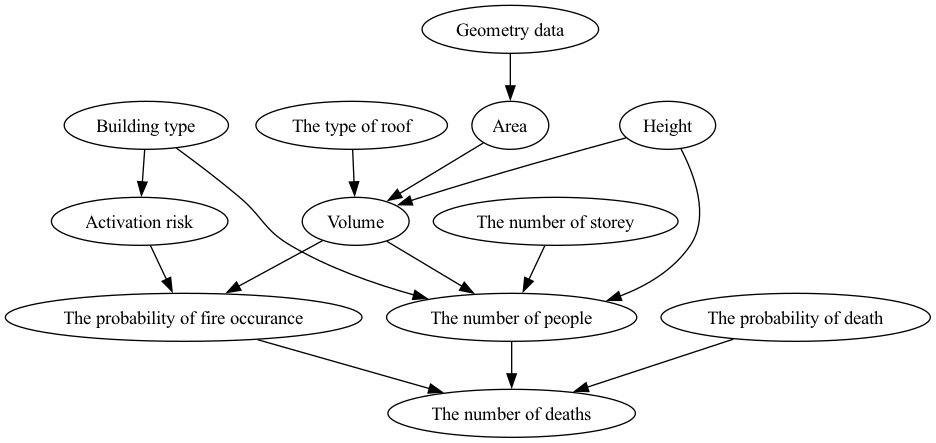

In [ ]:
viz = BN_risk.to_graphviz()
viz.draw('../Output/Model_images/model.png', prog='dot')
Image('../Output/Model_images/model.png')

## The basic BN with Fire risk model

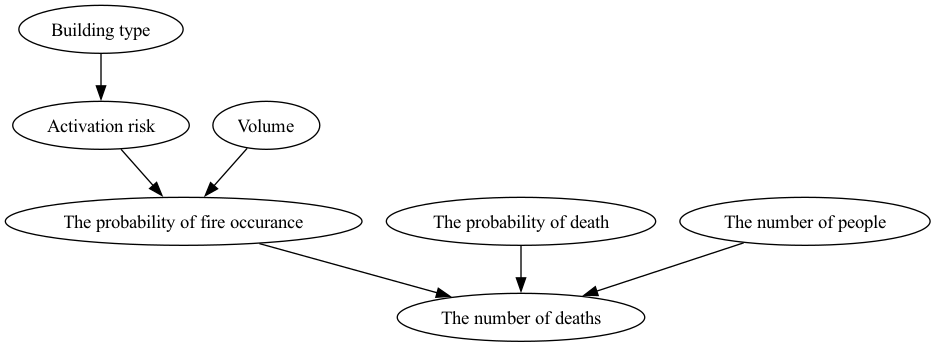

In [ ]:
BN_risk = DAG()
BN_risk.add_nodes_from(nodes=['Building type'])
BN_risk.add_edges_from(ebunch=[('Building type', 'Activation risk')])
BN_risk.add_edges_from(ebunch=[('Volume', 'The probability of fire occurance'),
                               ('Activation risk', 'The probability of fire occurance')])
BN_risk.add_edges_from(ebunch=[('The probability of fire occurance', 'The number of deaths'),
                               ('The probability of death', 'The number of deaths'),
                               ('The number of people', 'The number of deaths')])

# The expected numebr of deaths is just an risk indicator
viz = BN_risk.to_graphviz()
viz.draw('../Output/Model_images/model.png', prog='dot')
Image('../Output/Model_images/model.png')

### The Discrete BN model

Flexibility: Change BUILDING_TYPE (0, 1, or 2) to analyze different risk scenarios<br/>
Accuracy: Quantile-based binning ensures all probability bins are meaningful<br/>
Efficiency: Discrete BN allows fast exact inference with Variable Elimination<br/>
Interpretability: Both discrete bins and continuous value interpretations available<br/>

In [ ]:
# NOTE
# The first part: 
# number_of_people (for one building and functions)

# The second part: 
# GIS_data (number of occupants for all buildings)

# The code for one buidling is in Discretization.py file

# The third part: 
# BNs (this file) for outputting the analysis for all buildings

# output: csv file with all discrete distributions

### The code for outputting the analysis for all buildings

#### Block 1
this block works, output detailed distribution but in a long form 

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from scipy import integrate, stats
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# ============================================================================
# Configuration
# ============================================================================
N_BINS = 5  # Number of bins for continuous variables
N_DEATH_BINS = 10  # Number of bins for expected deaths
N_SAMPLES = 10000  # Number of samples for inference

# Risk factors
risk_factors_array = {
    'alpha': np.array([-9.011, -9.005, -9.422]),
    'beta':  np.array([0.434, 0.536, 0.669]),
    'gamma': np.array([0.018, 0.034, 0.030])
}

risk_level_map = {0: "Low Risk", 1: "Middle Risk", 2: "High Risk"}


# ============================================================================
# Helper Classes
# ============================================================================

class ContinuousToDiscreteCPD:
    """Helper class to discretize continuous distributions into TabularCPD using quantile binning"""
    
    def __init__(self, variable_name, n_bins, distribution, dist_params):
        self.variable_name = variable_name
        self.n_bins = n_bins
        self.distribution = distribution
        self.dist_params = dist_params
        
        # Calculate bins based on quantiles
        quantiles = np.linspace(0.001, 0.999, n_bins + 1)
        self.bins = distribution.ppf(quantiles, **dist_params)
        self.bin_means = self._calculate_bin_means()
        
    def _calculate_bin_means(self):
        """Calculate the mean value within each bin using numerical integration"""
        bin_means = []
        
        for i in range(self.n_bins):
            lower = self.bins[i]
            upper = self.bins[i + 1]
            
            def weighted_pdf(x):
                return x * self.distribution.pdf(x, **self.dist_params)
            
            numerator, _ = integrate.quad(weighted_pdf, lower, upper)
            denominator = (self.distribution.cdf(upper, **self.dist_params) - 
                          self.distribution.cdf(lower, **self.dist_params))
            
            if denominator < 1e-10:
                bin_mean = (lower + upper) / 2
            else:
                bin_mean = numerator / denominator
            
            bin_means.append(bin_mean)
        
        return np.array(bin_means)
    
    def get_probabilities(self):
        """Calculate discrete probabilities for each bin"""
        probs = []
        for i in range(self.n_bins):
            prob = (self.distribution.cdf(self.bins[i+1], **self.dist_params) - 
                   self.distribution.cdf(self.bins[i], **self.dist_params))
            probs.append(prob)
        
        probs = np.array(probs)
        probs = probs / probs.sum()
        return probs
    
    def continuous_from_bin(self, bin_index):
        """Convert a bin index back to a representative continuous value (bin mean)"""
        if 0 <= bin_index < self.n_bins:
            return self.bin_means[bin_index]
        else:
            raise ValueError(f"Bin index {bin_index} out of range")
    
    def get_cpd(self):
        """Create TabularCPD for this variable"""
        probs = self.get_probabilities().reshape(-1, 1)
        return TabularCPD(
            variable=self.variable_name,
            variable_card=self.n_bins,
            values=probs
        )


class DeterministicVariableBinner:
    """Helper class to bin deterministic derived variables using quantile binning"""
    
    def __init__(self, variable_name, n_bins, all_possible_values):
        self.variable_name = variable_name
        self.n_bins = n_bins
        
        # Create quantile-based bins
        quantiles = np.linspace(0, 1, n_bins + 1)
        self.bins = np.quantile(all_possible_values, quantiles)
        
        # Ensure unique bins
        self.bins = np.unique(self.bins)
        if len(self.bins) < n_bins + 1:
            self.bins = np.linspace(min(all_possible_values), 
                                   max(all_possible_values), 
                                   n_bins + 1)
        
        self.bin_means = self._calculate_bin_means(all_possible_values)
        
    def _calculate_bin_means(self, all_values):
        """Calculate the empirical mean of values in each bin"""
        bin_means = []
        
        for i in range(len(self.bins) - 1):
            lower = self.bins[i]
            upper = self.bins[i + 1]
            
            if i < len(self.bins) - 2:
                mask = (all_values >= lower) & (all_values < upper)
            else:
                mask = (all_values >= lower) & (all_values <= upper)
            
            values_in_bin = all_values[mask]
            
            if len(values_in_bin) > 0:
                bin_mean = np.mean(values_in_bin)
            else:
                bin_mean = (lower + upper) / 2
            
            bin_means.append(bin_mean)
        
        return np.array(bin_means)
    
    def discretize_value(self, continuous_value):
        """Convert a continuous value to discrete bin index"""
        return np.digitize(continuous_value, self.bins[1:-1])
    
    def continuous_from_bin(self, bin_index):
        """Convert a bin index back to a representative continuous value (bin mean)"""
        if 0 <= bin_index < len(self.bin_means):
            return self.bin_means[bin_index]
        else:
            raise ValueError(f"Bin index {bin_index} out of range")


def create_deterministic_cpd(child, parents, parent_cards, func):
    """Create a CPD for deterministic relationships"""
    parent_combos = list(product(*[range(card) for card in parent_cards]))
    n_combos = len(parent_combos)
    
    child_vals = [func(*combo) for combo in parent_combos]
    child_card = max(child_vals) + 1
    
    cpd_values = np.zeros((child_card, n_combos))
    
    for i, parent_vals in enumerate(parent_combos):
        child_val = func(*parent_vals)
        cpd_values[child_val, i] = 1.0
    
    return TabularCPD(child, child_card, cpd_values,
                     evidence=parents, evidence_card=parent_cards)


# ============================================================================
# Bayesian Network Builder
# ============================================================================

class BuildingRiskBayesianNetwork:
    """Build and run Bayesian Network for a single building"""
    
    def __init__(self, building_type, num_occupants, volume):
        self.building_type = building_type
        self.num_occupants = num_occupants
        self.volume = volume
        
        # Initialize discretizers
        self._initialize_discretizers()
        
        # Build the network
        self.model = self._build_network()
        
    def _initialize_discretizers(self):
        """Initialize all continuous variable discretizers"""
        # People: Uniform distribution around observed value
        self.people_disc = ContinuousToDiscreteCPD(
            variable_name='People',
            n_bins=N_BINS,
            distribution=stats.uniform,
            dist_params={'loc': max(0, self.num_occupants - 5), 'scale': 10}
        )
        
        # Volume: Normal distribution
        self.volume_disc = ContinuousToDiscreteCPD(
            variable_name='Volume',
            n_bins=N_BINS,
            distribution=stats.norm,
            dist_params={'loc': self.volume, 'scale': 50}
        )
        
        # Probability of Death: Beta distribution
        self.prob_death_disc = ContinuousToDiscreteCPD(
            variable_name='Prob_Death',
            n_bins=N_BINS,
            distribution=stats.beta,
            dist_params={'a': 413.5, 'b': 176171.5}
        )
        
        # Fire probability binner
        fire_probs_all = []
        for ar in range(3):
            for vol_bin in range(N_BINS):
                volume_val = self.volume_disc.bin_means[vol_bin]
                fire_prob = self._compute_fire_prob(volume_val, ar)
                fire_probs_all.append(fire_prob)
        
        self.fire_prob_binner = DeterministicVariableBinner(
            variable_name='Fire_Probability',
            n_bins=N_BINS,
            all_possible_values=np.array(fire_probs_all)
        )
        
        # Expected deaths binner
        deaths_all = []
        for people_bin in range(N_BINS):
            for fire_bin in range(len(self.fire_prob_binner.bin_means)):
                for death_bin in range(N_BINS):
                    people_val = self.people_disc.bin_means[people_bin]
                    fire_val = self.fire_prob_binner.bin_means[fire_bin]
                    prob_death_val = self.prob_death_disc.bin_means[death_bin]
                    
                    expected_death = people_val * fire_val * prob_death_val
                    deaths_all.append(expected_death)
        
        self.expected_deaths_binner = DeterministicVariableBinner(
            variable_name='Expected_Deaths',
            n_bins=N_DEATH_BINS,
            all_possible_values=np.array(deaths_all)
        )
    
    def _compute_fire_prob(self, volume_val, ar_level):
        """Compute fire probability for given volume value and AR level"""
        alpha = risk_factors_array['alpha'][ar_level]
        beta = risk_factors_array['beta'][ar_level]
        gamma = risk_factors_array['gamma'][ar_level]
        
        prob_fire = 2/np.pi * np.arctan(
            1.0 * np.exp(alpha) * volume_val ** beta / np.exp(21 * gamma)
        )
        return prob_fire
    
    def _build_network(self):
        """Build the complete Bayesian Network"""
        # Building Type CPD
        building_type_cpd = TabularCPD(
            variable='Building_Type',
            variable_card=3,
            values=[[1.0 if i == self.building_type else 0.0] for i in range(3)]
        )
        
        # Activation Risk CPD
        ar_values = np.array([
            [0.985, 0.01, 0.005],
            [0.01, 0.98, 0.01],
            [0.005, 0.01, 0.985]
        ])
        
        activation_risk_cpd = TabularCPD(
            variable='Activation_Risk',
            variable_card=3,
            values=ar_values,
            evidence=['Building_Type'],
            evidence_card=[3]
        )
        
        # Fire Probability CPD
        def fire_prob_func(volume_bin, ar_level):
            volume_val = self.volume_disc.bin_means[volume_bin]
            prob_fire = self._compute_fire_prob(volume_val, ar_level)
            fire_bin = self.fire_prob_binner.discretize_value(prob_fire)
            return fire_bin
        
        fire_probability_cpd = create_deterministic_cpd(
            child='Fire_Probability',
            parents=['Volume', 'Activation_Risk'],
            parent_cards=[N_BINS, 3],
            func=fire_prob_func
        )
        
        # Expected Deaths CPD
        def expected_deaths_func(people_bin, fire_bin, death_bin):
            people_val = self.people_disc.bin_means[people_bin]
            fire_val = self.fire_prob_binner.bin_means[fire_bin]
            prob_death_val = self.prob_death_disc.bin_means[death_bin]
            
            expected_death = people_val * fire_val * prob_death_val
            death_state = self.expected_deaths_binner.discretize_value(expected_death)
            return death_state
        
        expected_deaths_cpd = create_deterministic_cpd(
            child='Expected_Deaths',
            parents=['People', 'Fire_Probability', 'Prob_Death'],
            parent_cards=[N_BINS, len(self.fire_prob_binner.bin_means), N_BINS],
            func=expected_deaths_func
        )
        
        # Build model
        model = DiscreteBayesianNetwork([
            ('Building_Type', 'Activation_Risk'),
            ('Volume', 'Fire_Probability'),
            ('Activation_Risk', 'Fire_Probability'),
            ('Fire_Probability', 'Expected_Deaths'),
            ('People', 'Expected_Deaths'),
            ('Prob_Death', 'Expected_Deaths')
        ])
        
        # Add CPDs
        model.add_cpds(
            building_type_cpd,
            activation_risk_cpd,
            self.people_disc.get_cpd(),
            self.volume_disc.get_cpd(),
            self.prob_death_disc.get_cpd(),
            fire_probability_cpd,
            expected_deaths_cpd
        )
        
        assert model.check_model(), "Model validation failed!"
        
        return model
    
    def get_expected_deaths_distribution(self):
        """
        Get the distribution of expected deaths
        
        Returns:
            dict: Dictionary with bin means as keys and probabilities as values
        """
        inference = VariableElimination(self.model)
        result = inference.query(['Expected_Deaths'])
        
        # Create distribution dictionary
        distribution = {}
        for bin_idx, prob in enumerate(result.values):
            if prob > 1e-10:  # Only include non-zero probabilities
                bin_mean = self.expected_deaths_binner.bin_means[bin_idx]
                distribution[bin_mean] = prob
        
        return distribution
    
    def sample_expected_deaths(self, n_samples=N_SAMPLES):
        """
        Sample from the network and return expected deaths samples
        
        Returns:
            np.array: Array of expected deaths values (continuous)
        """
        sampler = BayesianModelSampling(self.model)
        samples = sampler.forward_sample(size=n_samples)
        
        # Convert to continuous values
        expected_deaths_values = samples['Expected_Deaths'].apply(
            lambda x: self.expected_deaths_binner.continuous_from_bin(x)
        ).values
        
        return expected_deaths_values


# ============================================================================
# Process Multiple Buildings
# ============================================================================

def process_buildings(buildings_gdf, building_type_col='building_type'):
    """
    Process multiple buildings and return expected deaths distributions
    
    Args:
        buildings_gdf: GeoDataFrame with building information
        building_type_col: Column name for building type (default: 'building_type')
    
    Returns:
        pd.DataFrame: DataFrame with gml_id, bin means, and probabilities
    """
    results = []
    
    print(f"Processing {len(buildings_gdf)} buildings...")
    
    for idx in tqdm(range(len(buildings_gdf))):
        building = buildings_gdf.iloc[idx]
        
        # Extract building parameters
        gml_id = building['gml_id']
        num_occupants = building['total_occupants']
        building_type = 2
        
        # Calculate volume (you may need to adjust this based on your data)
        # For now, using a placeholder calculation
        volume = building.get('_volume', 1865.1)  # Use actual volume if available
        
        
        try:
            # Build Bayesian Network
            bn = BuildingRiskBayesianNetwork(
                building_type=int(building_type),
                num_occupants=num_occupants,
                volume=volume
            )
            
            # Get expected deaths distribution
            distribution = bn.get_expected_deaths_distribution()
            
            # Create result rows (one per bin with non-zero probability)
            for bin_mean, probability in distribution.items():
                results.append({
                    'gml_id': gml_id,
                    'expected_deaths_bin_mean': bin_mean,
                    'probability': probability,
                    'building_type': building_type,
                    'num_occupants': num_occupants,
                    'volume': volume
                })
        
        except Exception as e:
            print(f"\nError processing building {gml_id}: {str(e)}")
            continue
    
    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


def aggregate_building_statistics(results_df):
    """
    Compute aggregate statistics for each building
    
    Args:
        results_df: DataFrame from process_buildings()
    
    Returns:
        pd.DataFrame: Aggregated statistics per building
    """
    agg_results = []
    
    for gml_id in results_df['gml_id'].unique():
        building_data = results_df[results_df['gml_id'] == gml_id]
        
        # Calculate expected value (mean)
        expected_value = (building_data['expected_deaths_bin_mean'] * 
                         building_data['probability']).sum()
        
        # Calculate variance
        variance = ((building_data['expected_deaths_bin_mean'] ** 2) * 
                   building_data['probability']).sum() - expected_value ** 2
        
        std_dev = np.sqrt(variance)
        
        # Get quantiles (approximate)
        cumulative_prob = building_data.sort_values('expected_deaths_bin_mean')['probability'].cumsum()
        sorted_means = building_data.sort_values('expected_deaths_bin_mean')['expected_deaths_bin_mean']
        
        q025 = sorted_means[cumulative_prob >= 0.025].iloc[0] if any(cumulative_prob >= 0.025) else sorted_means.iloc[0]
        q50 = sorted_means[cumulative_prob >= 0.50].iloc[0] if any(cumulative_prob >= 0.50) else sorted_means.iloc[len(sorted_means)//2]
        q975 = sorted_means[cumulative_prob >= 0.975].iloc[0] if any(cumulative_prob >= 0.975) else sorted_means.iloc[-1]
        
        agg_results.append({
            'gml_id': gml_id,
            'expected_deaths_mean': expected_value,
            'expected_deaths_std': std_dev,
            'expected_deaths_q025': q025,
            'expected_deaths_median': q50,
            'expected_deaths_q975': q975,
            'building_type': building_data['building_type'].iloc[0],
            'num_occupants': building_data['num_occupants'].iloc[0],
            'volume': building_data['volume'].iloc[0]
        })
    
    return pd.DataFrame(agg_results)


# ============================================================================
# Main Execution
# ============================================================================

if __name__ == "__main__":
    # Load data
    print("Loading building data...")
    complete_gdf = gpd.read_file("../Test data/buildings_with_occupants.geojson")
    
    # Extract residential buildings
    residential_gdf = complete_gdf[complete_gdf['citygml_function'] == '31001_1000'].copy()
    
    print(f"Found {len(residential_gdf)} residential buildings")
    
    # Process all buildings
    results_df = process_buildings(residential_gdf)
    
    # Save detailed results
    print("\nSaving detailed results...")
    results_df.to_csv('../Output/Data/building_risk_detailed_results.csv', index=False)
    print(f"Detailed results saved with {len(results_df)} rows")
    
    # Compute and save aggregate statistics
    print("\nComputing aggregate statistics...")
    agg_df = aggregate_building_statistics(results_df)
    agg_df.to_csv('../Output/Data/building_risk_summary_statistics_b1.csv', index=False)
    print(f"Summary statistics saved for {len(agg_df)} buildings")
    
    # Display sample results
    print("\n" + "="*70)
    print("SAMPLE RESULTS (First 5 buildings)")
    print("="*70)
    print("\nDetailed Distribution:")
    print(results_df.head(20))
    print("\nSummary Statistics:")
    print(agg_df.head())
    
    print("\n" + "="*70)
    print("PROCESSING COMPLETE")
    print("="*70)
    print(f"Total buildings processed: {len(agg_df)}")
    print(f"Mean expected deaths across all buildings: {agg_df['expected_deaths_mean'].mean():.6f}")
    print(f"Total expected deaths (sum): {agg_df['expected_deaths_mean'].sum():.6f}")



Loading building data...
Found 2877 residential buildings
Processing 2877 buildings...


100%|██████████| 2877/2877 [00:23<00:00, 122.40it/s]



Saving detailed results...
Detailed results saved with 28698 rows

Computing aggregate statistics...
Summary statistics saved for 2877 buildings

SAMPLE RESULTS (First 5 buildings)

Detailed Distribution:
             gml_id  expected_deaths_bin_mean  probability  building_type  \
0   DEBY_LOD2_59990                  0.000063      0.00168              2   
1   DEBY_LOD2_59990                  0.000077      0.00164              2   
2   DEBY_LOD2_59990                  0.000088      0.00200              2   
3   DEBY_LOD2_59990                  0.000099      0.00216              2   
4   DEBY_LOD2_59990                  0.000114      0.00240              2   
5   DEBY_LOD2_59990                  0.000143      0.01872              2   
6   DEBY_LOD2_59990                  0.000184      0.19008              2   
7   DEBY_LOD2_59990                  0.000223      0.25272              2   
8   DEBY_LOD2_59990                  0.000259      0.23688              2   
9   DEBY_LOD2_59990     

#### Block 2
this block is the newest version, output both wide and long version, but will exclude outliers automatically

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from scipy import integrate, stats
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# ============================================================================
# Configuration
# ============================================================================
N_BINS = 5  # Number of bins for continuous variables
N_DEATH_BINS = 10  # Number of bins for expected deaths
N_SAMPLES = 10000  # Number of samples for inference

# Risk factors
risk_factors_array = {
    'alpha': np.array([-9.011, -9.005, -9.422]),
    'beta':  np.array([0.434, 0.536, 0.669]),
    'gamma': np.array([0.018, 0.034, 0.030])
}

risk_level_map = {0: "Low Risk", 1: "Middle Risk", 2: "High Risk"}


# ============================================================================
# Helper Classes
# ============================================================================

class ContinuousToDiscreteCPD:
    """Helper class to discretize continuous distributions into TabularCPD using quantile binning"""
    
    def __init__(self, variable_name, n_bins, distribution, dist_params):
        self.variable_name = variable_name
        self.n_bins = n_bins
        self.distribution = distribution
        self.dist_params = dist_params
        
        # Calculate bins based on quantiles
        quantiles = np.linspace(0.001, 0.999, n_bins + 1)
        self.bins = distribution.ppf(quantiles, **dist_params)
        self.bin_means = self._calculate_bin_means()
        
    def _calculate_bin_means(self):
        """Calculate the mean value within each bin using numerical integration"""
        bin_means = []
        
        for i in range(self.n_bins):
            lower = self.bins[i]
            upper = self.bins[i + 1]
            
            def weighted_pdf(x):
                return x * self.distribution.pdf(x, **self.dist_params)
            
            numerator, _ = integrate.quad(weighted_pdf, lower, upper)
            denominator = (self.distribution.cdf(upper, **self.dist_params) - 
                          self.distribution.cdf(lower, **self.dist_params))
            
            if denominator < 1e-10:
                bin_mean = (lower + upper) / 2
            else:
                bin_mean = numerator / denominator
            
            bin_means.append(bin_mean)
        
        return np.array(bin_means)
    
    def get_probabilities(self):
        """Calculate discrete probabilities for each bin"""
        probs = []
        for i in range(self.n_bins):
            prob = (self.distribution.cdf(self.bins[i+1], **self.dist_params) - 
                   self.distribution.cdf(self.bins[i], **self.dist_params))
            probs.append(prob)
        
        probs = np.array(probs)
        probs = probs / probs.sum()
        return probs
    
    def continuous_from_bin(self, bin_index):
        """Convert a bin index back to a representative continuous value (bin mean)"""
        if 0 <= bin_index < self.n_bins:
            return self.bin_means[bin_index]
        else:
            raise ValueError(f"Bin index {bin_index} out of range")
    
    def get_cpd(self):
        """Create TabularCPD for this variable"""
        probs = self.get_probabilities().reshape(-1, 1)
        return TabularCPD(
            variable=self.variable_name,
            variable_card=self.n_bins,
            values=probs
        )


class DeterministicVariableBinner:
    """Helper class to bin deterministic derived variables using quantile binning"""
    
    def __init__(self, variable_name, n_bins, all_possible_values):
        self.variable_name = variable_name
        self.n_bins = n_bins
        
        # Create quantile-based bins
        quantiles = np.linspace(0, 1, n_bins + 1)
        self.bins = np.quantile(all_possible_values, quantiles)
        
        # Ensure unique bins
        self.bins = np.unique(self.bins)
        if len(self.bins) < n_bins + 1:
            self.bins = np.linspace(min(all_possible_values), 
                                   max(all_possible_values), 
                                   n_bins + 1)
        
        self.bin_means = self._calculate_bin_means(all_possible_values)
        
    def _calculate_bin_means(self, all_values):
        """Calculate the empirical mean of values in each bin"""
        bin_means = []
        
        for i in range(len(self.bins) - 1):
            lower = self.bins[i]
            upper = self.bins[i + 1]
            
            if i < len(self.bins) - 2:
                mask = (all_values >= lower) & (all_values < upper)
            else:
                mask = (all_values >= lower) & (all_values <= upper)
            
            values_in_bin = all_values[mask]
            
            if len(values_in_bin) > 0:
                bin_mean = np.mean(values_in_bin)
            else:
                bin_mean = (lower + upper) / 2
            
            bin_means.append(bin_mean)
        
        return np.array(bin_means)
    
    def discretize_value(self, continuous_value):
        """Convert a continuous value to discrete bin index"""
        return np.digitize(continuous_value, self.bins[1:-1])
    
    def continuous_from_bin(self, bin_index):
        """Convert a bin index back to a representative continuous value (bin mean)"""
        if 0 <= bin_index < len(self.bin_means):
            return self.bin_means[bin_index]
        else:
            raise ValueError(f"Bin index {bin_index} out of range")


def create_deterministic_cpd(child, parents, parent_cards, func):
    """Create a CPD for deterministic relationships"""
    parent_combos = list(product(*[range(card) for card in parent_cards]))
    n_combos = len(parent_combos)
    
    child_vals = [func(*combo) for combo in parent_combos]
    child_card = max(child_vals) + 1
    
    cpd_values = np.zeros((child_card, n_combos))
    
    for i, parent_vals in enumerate(parent_combos):
        child_val = func(*parent_vals)
        cpd_values[child_val, i] = 1.0
    
    return TabularCPD(child, child_card, cpd_values,
                     evidence=parents, evidence_card=parent_cards)


# ============================================================================
# Bayesian Network Builder
# ============================================================================

class BuildingRiskBayesianNetwork:
    """Build and run Bayesian Network for a single building"""
    
    def __init__(self, building_type, num_occupants, volume):
        self.building_type = building_type
        self.num_occupants = num_occupants
        self.volume = volume
        
        # Initialize discretizers
        self._initialize_discretizers()
        
        # Build the network
        self.model = self._build_network()
        
    def _initialize_discretizers(self):
        """Initialize all continuous variable discretizers"""
        # People: Uniform distribution around observed value
        self.people_disc = ContinuousToDiscreteCPD(
            variable_name='People',
            n_bins=N_BINS,
            distribution=stats.uniform,
            dist_params={'loc': max(0, self.num_occupants - 5), 'scale': 10}
        )
        
        # Volume: Normal distribution
        self.volume_disc = ContinuousToDiscreteCPD(
            variable_name='Volume',
            n_bins=N_BINS,
            distribution=stats.norm,
            dist_params={'loc': self.volume, 'scale': 50}
        )
        
        # Probability of Death: Beta distribution
        self.prob_death_disc = ContinuousToDiscreteCPD(
            variable_name='Prob_Death',
            n_bins=N_BINS,
            distribution=stats.beta,
            dist_params={'a': 413.5, 'b': 176171.5}
        )
        
        # Fire probability binner
        fire_probs_all = []
        for ar in range(3):
            for vol_bin in range(N_BINS):
                volume_val = self.volume_disc.bin_means[vol_bin]
                fire_prob = self._compute_fire_prob(volume_val, ar)
                fire_probs_all.append(fire_prob)
        
        self.fire_prob_binner = DeterministicVariableBinner(
            variable_name='Fire_Probability',
            n_bins=N_BINS,
            all_possible_values=np.array(fire_probs_all)
        )
        
        # Expected deaths binner
        deaths_all = []
        for people_bin in range(N_BINS):
            for fire_bin in range(len(self.fire_prob_binner.bin_means)):
                for death_bin in range(N_BINS):
                    people_val = self.people_disc.bin_means[people_bin]
                    fire_val = self.fire_prob_binner.bin_means[fire_bin]
                    prob_death_val = self.prob_death_disc.bin_means[death_bin]
                    
                    expected_death = people_val * fire_val * prob_death_val
                    deaths_all.append(expected_death)
        
        self.expected_deaths_binner = DeterministicVariableBinner(
            variable_name='Expected_Deaths',
            n_bins=N_DEATH_BINS,
            all_possible_values=np.array(deaths_all)
        )
    
    def _compute_fire_prob(self, volume_val, ar_level):
        """Compute fire probability for given volume value and AR level"""
        alpha = risk_factors_array['alpha'][ar_level]
        beta = risk_factors_array['beta'][ar_level]
        gamma = risk_factors_array['gamma'][ar_level]
        
        prob_fire = 2/np.pi * np.arctan(
            1.0 * np.exp(alpha) * volume_val ** beta / np.exp(21 * gamma)
        )
        return prob_fire
    
    def _build_network(self):
        """Build the complete Bayesian Network"""
        # Building Type CPD
        building_type_cpd = TabularCPD(
            variable='Building_Type',
            variable_card=3,
            values=[[1.0 if i == self.building_type else 0.0] for i in range(3)]
        )
        
        # Activation Risk CPD
        ar_values = np.array([
            [0.985, 0.01, 0.005],
            [0.01, 0.98, 0.01],
            [0.005, 0.01, 0.985]
        ])
        
        activation_risk_cpd = TabularCPD(
            variable='Activation_Risk',
            variable_card=3,
            values=ar_values,
            evidence=['Building_Type'],
            evidence_card=[3]
        )
        
        # Fire Probability CPD
        def fire_prob_func(volume_bin, ar_level):
            volume_val = self.volume_disc.bin_means[volume_bin]
            prob_fire = self._compute_fire_prob(volume_val, ar_level)
            fire_bin = self.fire_prob_binner.discretize_value(prob_fire)
            return fire_bin
        
        fire_probability_cpd = create_deterministic_cpd(
            child='Fire_Probability',
            parents=['Volume', 'Activation_Risk'],
            parent_cards=[N_BINS, 3],
            func=fire_prob_func
        )
        
        # Expected Deaths CPD
        def expected_deaths_func(people_bin, fire_bin, death_bin):
            people_val = self.people_disc.bin_means[people_bin]
            fire_val = self.fire_prob_binner.bin_means[fire_bin]
            prob_death_val = self.prob_death_disc.bin_means[death_bin]
            
            expected_death = people_val * fire_val * prob_death_val
            death_state = self.expected_deaths_binner.discretize_value(expected_death)
            return death_state
        
        expected_deaths_cpd = create_deterministic_cpd(
            child='Expected_Deaths',
            parents=['People', 'Fire_Probability', 'Prob_Death'],
            parent_cards=[N_BINS, len(self.fire_prob_binner.bin_means), N_BINS],
            func=expected_deaths_func
        )
        
        # Build model
        model = DiscreteBayesianNetwork([
            ('Building_Type', 'Activation_Risk'),
            ('Volume', 'Fire_Probability'),
            ('Activation_Risk', 'Fire_Probability'),
            ('Fire_Probability', 'Expected_Deaths'),
            ('People', 'Expected_Deaths'),
            ('Prob_Death', 'Expected_Deaths')
        ])
        
        # Add CPDs
        model.add_cpds(
            building_type_cpd,
            activation_risk_cpd,
            self.people_disc.get_cpd(),
            self.volume_disc.get_cpd(),
            self.prob_death_disc.get_cpd(),
            fire_probability_cpd,
            expected_deaths_cpd
        )
        
        assert model.check_model(), "Model validation failed!"
        
        return model
    
    def get_expected_deaths_distribution(self):
        """
        Get the complete discrete distribution of expected deaths
        
        Returns:
            tuple: (bin_means array, probabilities array)
        """
        inference = VariableElimination(self.model)
        result = inference.query(['Expected_Deaths'])
        
        # Get all bin means and probabilities (including zeros)
        bin_means = self.expected_deaths_binner.bin_means
        probabilities = result.values
        
        return bin_means, probabilities
    
    def get_distribution_dict(self):
        """
        Get distribution as dictionary
        
        Returns:
            dict: {bin_idx: {'bin_mean': value, 'probability': prob}}
        """
        bin_means, probabilities = self.get_expected_deaths_distribution()
        
        distribution_dict = {}
        for bin_idx in range(len(bin_means)):
            distribution_dict[bin_idx] = {
                'bin_mean': bin_means[bin_idx],
                'probability': probabilities[bin_idx]
            }
        
        return distribution_dict


# ============================================================================
# Process Multiple Buildings
# ============================================================================

def process_buildings(buildings_gdf, building_type_col='building_type'):
    """
    Process multiple buildings and return complete discrete distributions
    
    Args:
        buildings_gdf: GeoDataFrame with building information
        building_type_col: Column name for building type
    
    Returns:
        pd.DataFrame: DataFrame with complete distribution for each building
    """
    all_results = []
    
    print(f"Processing {len(buildings_gdf)} buildings...")
    
    for idx in tqdm(range(len(buildings_gdf))):
        building = buildings_gdf.iloc[idx]
        
        # Extract building parameters
        gml_id = building['gml_id']
        num_occupants = building['total_occupants']
        building_type = 2 # Activation risk is high for residential buildings
        
        # Calculate volume (adjust based on your data)
        volume = building.get('_volume', 1865.1)
        
        
        try:
            # Build Bayesian Network
            bn = BuildingRiskBayesianNetwork(
                building_type=int(building_type),
                num_occupants=num_occupants,
                volume=volume
            )
            
            # Get complete discrete distribution
            # ==========================================================================!!!!!!!!!!!!!!!!!!!!
            # Very important: get full distribution including zero probabilities
            # ========================================================================== 
            bin_means, probabilities = bn.get_expected_deaths_distribution()
            
            # Create row with all bins
            result_row = {
                'gml_id': gml_id,
                'building_type': building_type,
                'num_occupants': num_occupants,
                'volume': volume
            }
            
            # Add each bin's mean and probability
            for bin_idx in range(len(bin_means)):
                result_row[f'bin_{bin_idx}_mean'] = bin_means[bin_idx]
                result_row[f'bin_{bin_idx}_prob'] = probabilities[bin_idx]
            
            all_results.append(result_row)
        
        except Exception as e:
            print(f"\nError processing building {gml_id}: {str(e)}")
            continue
    
    # Create DataFrame
    results_df = pd.DataFrame(all_results)
    
    return results_df


def create_long_format_results(results_df):
    """
    Convert wide format to long format for easier analysis
    
    Args:
        results_df: Wide format DataFrame from process_buildings()
    
    Returns:
        pd.DataFrame: Long format with one row per building-bin combination
    """
    # Identify bin columns
    bin_mean_cols = [col for col in results_df.columns if col.startswith('bin_') and col.endswith('_mean')]
    bin_prob_cols = [col for col in results_df.columns if col.startswith('bin_') and col.endswith('_prob')]
    
    n_bins = len(bin_mean_cols)
    
    long_data = []
    
    for _, row in results_df.iterrows():
        gml_id = row['gml_id']
        building_type = row['building_type']
        num_occupants = row['num_occupants']
        volume = row['volume']
        
        for bin_idx in range(n_bins):
            bin_mean = row[f'bin_{bin_idx}_mean']
            bin_prob = row[f'bin_{bin_idx}_prob']
            
            long_data.append({
                'gml_id': gml_id,
                'building_type': building_type,
                'num_occupants': num_occupants,
                'volume': volume,
                'bin_index': bin_idx,
                'bin_mean': bin_mean,
                'probability': bin_prob
            })
    
    return pd.DataFrame(long_data)


def compute_statistics_from_distribution(results_df):
    """
    Compute summary statistics from the discrete distributions
    
    Args:
        results_df: Wide format DataFrame from process_buildings()
    
    Returns:
        pd.DataFrame: Summary statistics for each building
    """
    summary_data = []
    
    # Identify bin columns
    bin_mean_cols = [col for col in results_df.columns if col.startswith('bin_') and col.endswith('_mean')]
    bin_prob_cols = [col for col in results_df.columns if col.startswith('bin_') and col.endswith('_prob')]
    
    for _, row in results_df.iterrows():
        gml_id = row['gml_id']
        
        # Extract means and probabilities
        means = np.array([row[col] for col in bin_mean_cols])
        probs = np.array([row[col] for col in bin_prob_cols])
        
        # Calculate statistics
        expected_value = np.sum(means * probs)
        variance = np.sum((means ** 2) * probs) - expected_value ** 2
        std_dev = np.sqrt(variance)
        
        # Calculate quantiles
        cumulative_probs = np.cumsum(probs)
        q025_idx = np.searchsorted(cumulative_probs, 0.025)
        q50_idx = np.searchsorted(cumulative_probs, 0.50)
        q975_idx = np.searchsorted(cumulative_probs, 0.975)
        
        summary_data.append({
            'gml_id': gml_id,
            'expected_deaths_mean': expected_value,
            'expected_deaths_std': std_dev,
            'expected_deaths_q025': means[q025_idx],
            'expected_deaths_median': means[q50_idx],
            'expected_deaths_q975': means[q975_idx],
            'building_type': row['building_type'],
            'num_occupants': row['num_occupants'],
            'volume': row['volume']
        })
    
    return pd.DataFrame(summary_data)


# ============================================================================
# Main Execution
# ============================================================================

if __name__ == "__main__":
    # Load data
    print("Loading building data...")
    complete_gdf = gpd.read_file("../Test data/buildings_with_occupants.geojson")
    
    # Extract residential buildings
    residential_gdf = complete_gdf[complete_gdf['citygml_function'] == '31001_1000'].copy()
    

    print(f"Found {len(residential_gdf)} residential buildings")
    
    # Process all buildings - get complete discrete distributions
    print("\n" + "="*70)
    print("PROCESSING BUILDINGS")
    print("="*70)
    results_wide_df = process_buildings(residential_gdf)
    
    # Save wide format (complete distribution matrix)
    print("\nSaving complete distribution matrix (wide format)...")
    results_wide_df.to_csv('../Output/Data/building_risk_distributions_wide.csv', index=False)
    print(f"Wide format saved: {len(results_wide_df)} buildings × {N_DEATH_BINS} bins")
    
    # Create and save long format
    print("\nCreating long format...")
    results_long_df = create_long_format_results(results_wide_df)
    results_long_df.to_csv('../Output/Data/building_risk_distributions_long.csv', index=False)
    print(f"Long format saved: {len(results_long_df)} rows")
    
    # Compute and save summary statistics
    print("\nComputing summary statistics...")
    summary_df = compute_statistics_from_distribution(results_wide_df)
    summary_df.to_csv('../Output/Data/building_risk_summary_statistics_b2.csv', index=False)
    print(f"Summary statistics saved: {len(summary_df)} buildings")
    
    # Display sample results
    print("\n" + "="*70)
    print("SAMPLE RESULTS")
    print("="*70)
    
    print("\nWide Format (First building, first 5 bins):")
    print(results_wide_df.iloc[0][['gml_id', 'building_type', 'num_occupants', 
                                     'bin_0_mean', 'bin_0_prob',
                                     'bin_1_mean', 'bin_1_prob',
                                     'bin_2_mean', 'bin_2_prob',
                                     'bin_3_mean', 'bin_3_prob',
                                     'bin_4_mean', 'bin_4_prob']])
    
    print("\nLong Format (First 10 rows):")
    print(results_long_df.head(10))
    
    print("\nSummary Statistics (First 5 buildings):")
    print(summary_df.head())
    
    print("\n" + "="*70)
    print("OVERALL STATISTICS")
    print("="*70)
    print(f"Total buildings processed: {len(summary_df)}")
    print(f"Mean expected deaths across all buildings: {summary_df['expected_deaths_mean'].mean():.6f}")
    print(f"Total expected deaths (sum): {summary_df['expected_deaths_mean'].sum():.6f}")
    print(f"Min expected deaths: {summary_df['expected_deaths_mean'].min():.6f}")
    print(f"Max expected deaths: {summary_df['expected_deaths_mean'].max():.6f}")
    print("="*70)

Loading building data...
Found 2877 residential buildings

PROCESSING BUILDINGS
Processing 2877 buildings...


  2%|▏         | 52/2877 [00:00<00:22, 126.82it/s]


Error processing building DEBY_LOD2_60080: index 1 is out of bounds for axis 0 with size 1


 56%|█████▌    | 1602/2877 [00:12<00:10, 121.60it/s]


Error processing building DEBY_LOD2_4960099: index 1 is out of bounds for axis 0 with size 1


 95%|█████████▍| 2723/2877 [00:21<00:01, 122.50it/s]


Error processing building DEBY_LOD2_8573859: index 1 is out of bounds for axis 0 with size 1


 98%|█████████▊| 2814/2877 [00:22<00:00, 120.78it/s]


Error processing building DEBY_LOD2_107197318: index 1 is out of bounds for axis 0 with size 1

Error processing building DEBY_LOD2_107197495: index 1 is out of bounds for axis 0 with size 1


100%|█████████▉| 2864/2877 [00:23<00:00, 120.62it/s]


Error processing building DEBY_LOD2_108249973: index 1 is out of bounds for axis 0 with size 1

Error processing building DEBY_LOD2_108250087: index 1 is out of bounds for axis 0 with size 1

Error processing building DEBY_LOD2_108251752: index 1 is out of bounds for axis 0 with size 1


100%|██████████| 2877/2877 [00:23<00:00, 124.37it/s]



Saving complete distribution matrix (wide format)...
Wide format saved: 2869 buildings × 10 bins

Creating long format...
Long format saved: 28690 rows

Computing summary statistics...
Summary statistics saved: 2869 buildings

SAMPLE RESULTS

Wide Format (First building, first 5 bins):
gml_id           DEBY_LOD2_59990
building_type                  2
num_occupants               17.0
bin_0_mean              0.000063
bin_0_prob               0.00168
bin_1_mean              0.000077
bin_1_prob               0.00164
bin_2_mean              0.000088
bin_2_prob                 0.002
bin_3_mean              0.000099
bin_3_prob               0.00216
bin_4_mean              0.000114
bin_4_prob                0.0024
Name: 0, dtype: object

Long Format (First 10 rows):
            gml_id  building_type  num_occupants       volume  bin_index  \
0  DEBY_LOD2_59990              2           17.0  3753.066649          0   
1  DEBY_LOD2_59990              2           17.0  3753.066649          1   
2 

## The Geo data 

In [17]:
import geopandas as gpd
import random
import numpy as np
from dataclasses import dataclass
from typing import Optional

In [ ]:
# Read completed data file and display samples

complete_gdf = gpd.read_file("../Test data/buildings_with_occupants.geojson")

# have a look at the data
print(complete_gdf.head())
print(complete_gdf.sample(1))
print(complete_gdf.iloc[random.randint(0, len(complete_gdf)-1)])

            gml_id                                 gml_parent_id  \
0  DEBY_LOD2_59962  fme-gen-e77c37af-fc0c-4891-afdf-24a30e8baaa0   
1  DEBY_LOD2_59986  fme-gen-e77c37af-fc0c-4891-afdf-24a30e8baaa0   
2  DEBY_LOD2_59987  fme-gen-e77c37af-fc0c-4891-afdf-24a30e8baaa0   
3  DEBY_LOD2_59988  fme-gen-e77c37af-fc0c-4891-afdf-24a30e8baaa0   
4  DEBY_LOD2_59989  fme-gen-e77c37af-fc0c-4891-afdf-24a30e8baaa0   

                            citygml_target_uri citygml_feature_role gml_name  \
0  http://www.opengis.net/citygml/building/1.0     cityObjectMember     None   
1  http://www.opengis.net/citygml/building/1.0     cityObjectMember     None   
2  http://www.opengis.net/citygml/building/1.0     cityObjectMember     None   
3  http://www.opengis.net/citygml/building/1.0     cityObjectMember     None   
4  http://www.opengis.net/citygml/building/1.0     cityObjectMember     None   

  citygml_creationDate citygml_function citygml_roof_type  \
0           2021-04-20       31001_9998          

In [4]:
# Extract residential buildings
residential_gdf = complete_gdf[complete_gdf['citygml_function'] == '31001_1000']
print(f"Total residential buildings: {len(residential_gdf)}")

Total residential buildings: 2877


In [25]:
# A way to extract total occupants column
residential_gdf.iloc[:]["_volume"]

5       3753.066649
6       4123.457725
10       702.918895
11      1294.775875
15       250.443589
           ...     
6562    3081.786639
6563    5908.209081
6567    3134.794395
6570     584.643562
6571    5408.781052
Name: _volume, Length: 2877, dtype: float64